# Cecklist

## Frame the problem and look at big picture
[X] Define the objective.

    - predict winners of each game in world cup

[X] What are the current solutions if any

    - Many

[X] How should performance be measures

    - How well predictions come to fruition. 

[X] List the assumptions you or others have made so far.

    - spi will predict winner
    - gather SPI of starters for each team
    - use cummulative SPI for each team 

[ ] Verify assumptions if possible



## Get the Data
[X] List data you need and how much is needed

    - Historical World Cup data for wins and losses?
    - SPI of all starters on national teams

[ ] Find and document where you get data

[ ] Get the data

[ ] Convert the data to a format you can manipulate

[ ] Check size and type of data (time series, sample, geographial, etc.)

[ ] Sample a test set, put it aside, and don't look at it. 


## Explore the data to gain insights
Note: try to get insights from a field expert for these steps.

[ ] Create a copy of the data for exploration

[ ] Create a jupyter notebook to keep record of data 
exploration

[ ] Study each attribute and its characteristics:

    - Name    
    - Type (categorical, int/float, bount/unbounded, text, structured, etc.)
            - .info(), .describe(), .shape, .head()        
    - Noisiness and type of noise (stochastic, outliers, rounding errors, etc.   
    - Possibly useful for the task?
    - Type of distribution (Gaussian, uniform, logarithmic, etc.)

[ ] For supervised learning, Identify the target attribute(s)

[ ] Visualize the data.

[ ] Study the correlations between attributes

[ ] Identify promising transformations you may want to apply. 

[ ] Document what you have learned
    

## Prepare the data to better expose the underlying data patterns to ML algorithms
Notes: 

    - Work on copies of data (Keep the original dataset intact).
    - Write functions for all data transformation you apply, for 5 reasons:
        1. You can easily prepare the data the next time you get a fresh dataset
        2. ability to apply these transformations in future projects
        3. To clean and prepare the test set
        4. To clean and new data instances
        5. To make it easy to treate your preparation choices as hyperparamteres
 

[ ] **Data Clearning**:

    - Fix or remove outliers (optional)
    - Fill in missing values (e.g., with zero, mean, median, etc.) or drop rows (columns)

[ ] Feature Selection (optional)

    - Drop the attributes that provide no useful information for the task.

[ ] **Feature engineering**, where appropriate:

    - Discretize continuous features.
    - Decompose features (e.g., categorical, date/time, etc.)
    - Aggregate features into promising new features.

[ ] **Feature Scaling** 

    - Standardize or normalize features


## Explore many different models and short-list the best ones
note: try to automate these steps as much as possible.


[ ] Train many quick and dirty models from different categories, using standard parameters.

    - linear
    - naive
    - Bayes
    - SVM
    - Random Forest
    - Neural net
    - etc.

[ ] Measure and compare their performance

    - For each model, use **N-fold cross-validation** and compute the standard deviation of their performance.

[ ] Analyze the most significant variables for each algorithm

[ ] Analyze the types of errors the models make

[ ] Quick round of feature selection and engineering

[ ] One or two more quick iterations of the 5 previous steps

[ ] short-list the top three to five most promising models, preferring models that make different types of errors


## Fine-tune your models and combine them into a solution.
Note: 

    - you will want to use as much data as possible for this step, especially as you move toward the end of fine-tuning.
    - automate what you can
    

[ ] Find-tune hyperparameters using **cross-validation**

    - treat your data transformation choices asa hyperparameters, especially when you are note sure about them (e.g., should I replace missing values with zero or the median value, etc.)
    - Unless there are very few hyperparameter values to explore, prefer random search over grid search. If training is very long, you might prefer a Bayesian optimization approach(e.g., a gaussian process priors)

[ ] Try **Ensemble methods**. Combining your best models will often perform better than running them indiviually.

[ ] Once you are confident about your final model, measure its performance on the test set to estimate the generalization error. 

**Note: Don't tweak your model after measuring the generalization error: you would just start overfitting the test set.**


## Present solution

[ ] Document what you have done

[ ] Create Presentation


## Launch, monitor, and Maintain

### https://www.kaggle.com/code/launay10christian/world-cup-prediction/notebook

Good source for baseline

## Glossary

**SPI** - rating designed to provide the best possible objective representation of a team's current overall skill level.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.ticker as plticker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### Variables for wc 2018, 2014, 2010 and for teams in 2022 world cup

In [2]:
years = [2018, 2014, 2010]

In [3]:
teams_2022 = ['Qatar', 'Netherlands', 'Senegal', 'Ecuador', 'England', 'USA', 'Wales', 'Iran', 'Argentina', 'Poland', 'Mexico', 'Saudi Arabia', 'France', 'Denmark', 'Tunisia', 'Australia', 'Germany', 'Spain', 'Japan', 'Costa Rica', 'Belgium', 'Croatia', 'Canada', 'Morocco', 'Brazil', 'Switzerland', 'Serbia', 'Cameroon', 'Portugal', 'Uruguay', 'Ghana', 'Korea Republic']

## World Cup 2018 Matches  

In [4]:
matches = pd.read_csv('wc_matches.csv')

In [5]:
matches.head()

,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,probtie,proj_score1,proj_score2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
0,2018-06-14,1908,FIFA World Cup,Russia,Saudi Arabia,70.14,51.33,0.6615,0.1200,0.2184,2.03,0.73,5,0,1.62,0.20,1.55,0.11,4.18,0.00
1,2018-06-15,1908,FIFA World Cup,Egypt,Uruguay,62.46,79.52,0.1845,0.5433,0.2723,0.82,1.61,0,1,0.42,1.94,0.65,1.94,0.00,1.05
2,2018-06-15,1908,FIFA World Cup,Morocco,Iran,72.33,65.57,0.4004,0.2667,0.3330,1.13,0.86,0,1,0.86,0.72,0.57,0.36,0.00,1.05
3,2018-06-15,1908,FIFA World Cup,Portugal,Spain,83.47,91.30,0.2459,0.4809,0.2732,1.07,1.60,3,3,1.15,1.63,0.80,2.59,3.15,3.15
4,2018-06-16,1908,FIFA World Cup,France,Australia,87.18,61.69,0.7694,0.0746,0.1560,2.61,0.69,2,1,1.38,1.03,1.24,0.39,2.10,1.05


In [6]:
matches.columns

Index(['date', 'league_id', 'league', 'team1', 'team2', 'spi1', 'spi2',
       'prob1', 'prob2', 'probtie', 'proj_score1', 'proj_score2', 'score1',
       'score2', 'xg1', 'xg2', 'nsxg1', 'nsxg2', 'adj_score1', 'adj_score2'],
      dtype='object')

In [7]:
matches['date'] =  pd.to_datetime(matches['date'],  format="%Y/%m/%d")


In [8]:
matches = matches.set_index('date')

<AxesSubplot:xlabel='date'>

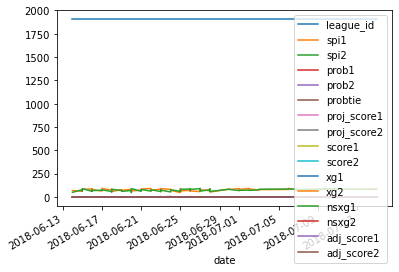

In [9]:
matches.plot()

<AxesSubplot:xlabel='date'>

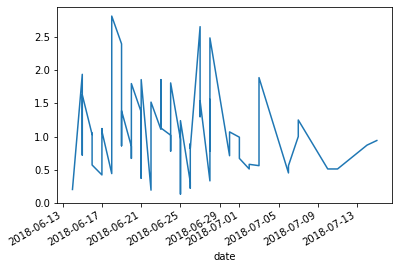

In [10]:
matches['xg2'].plot()

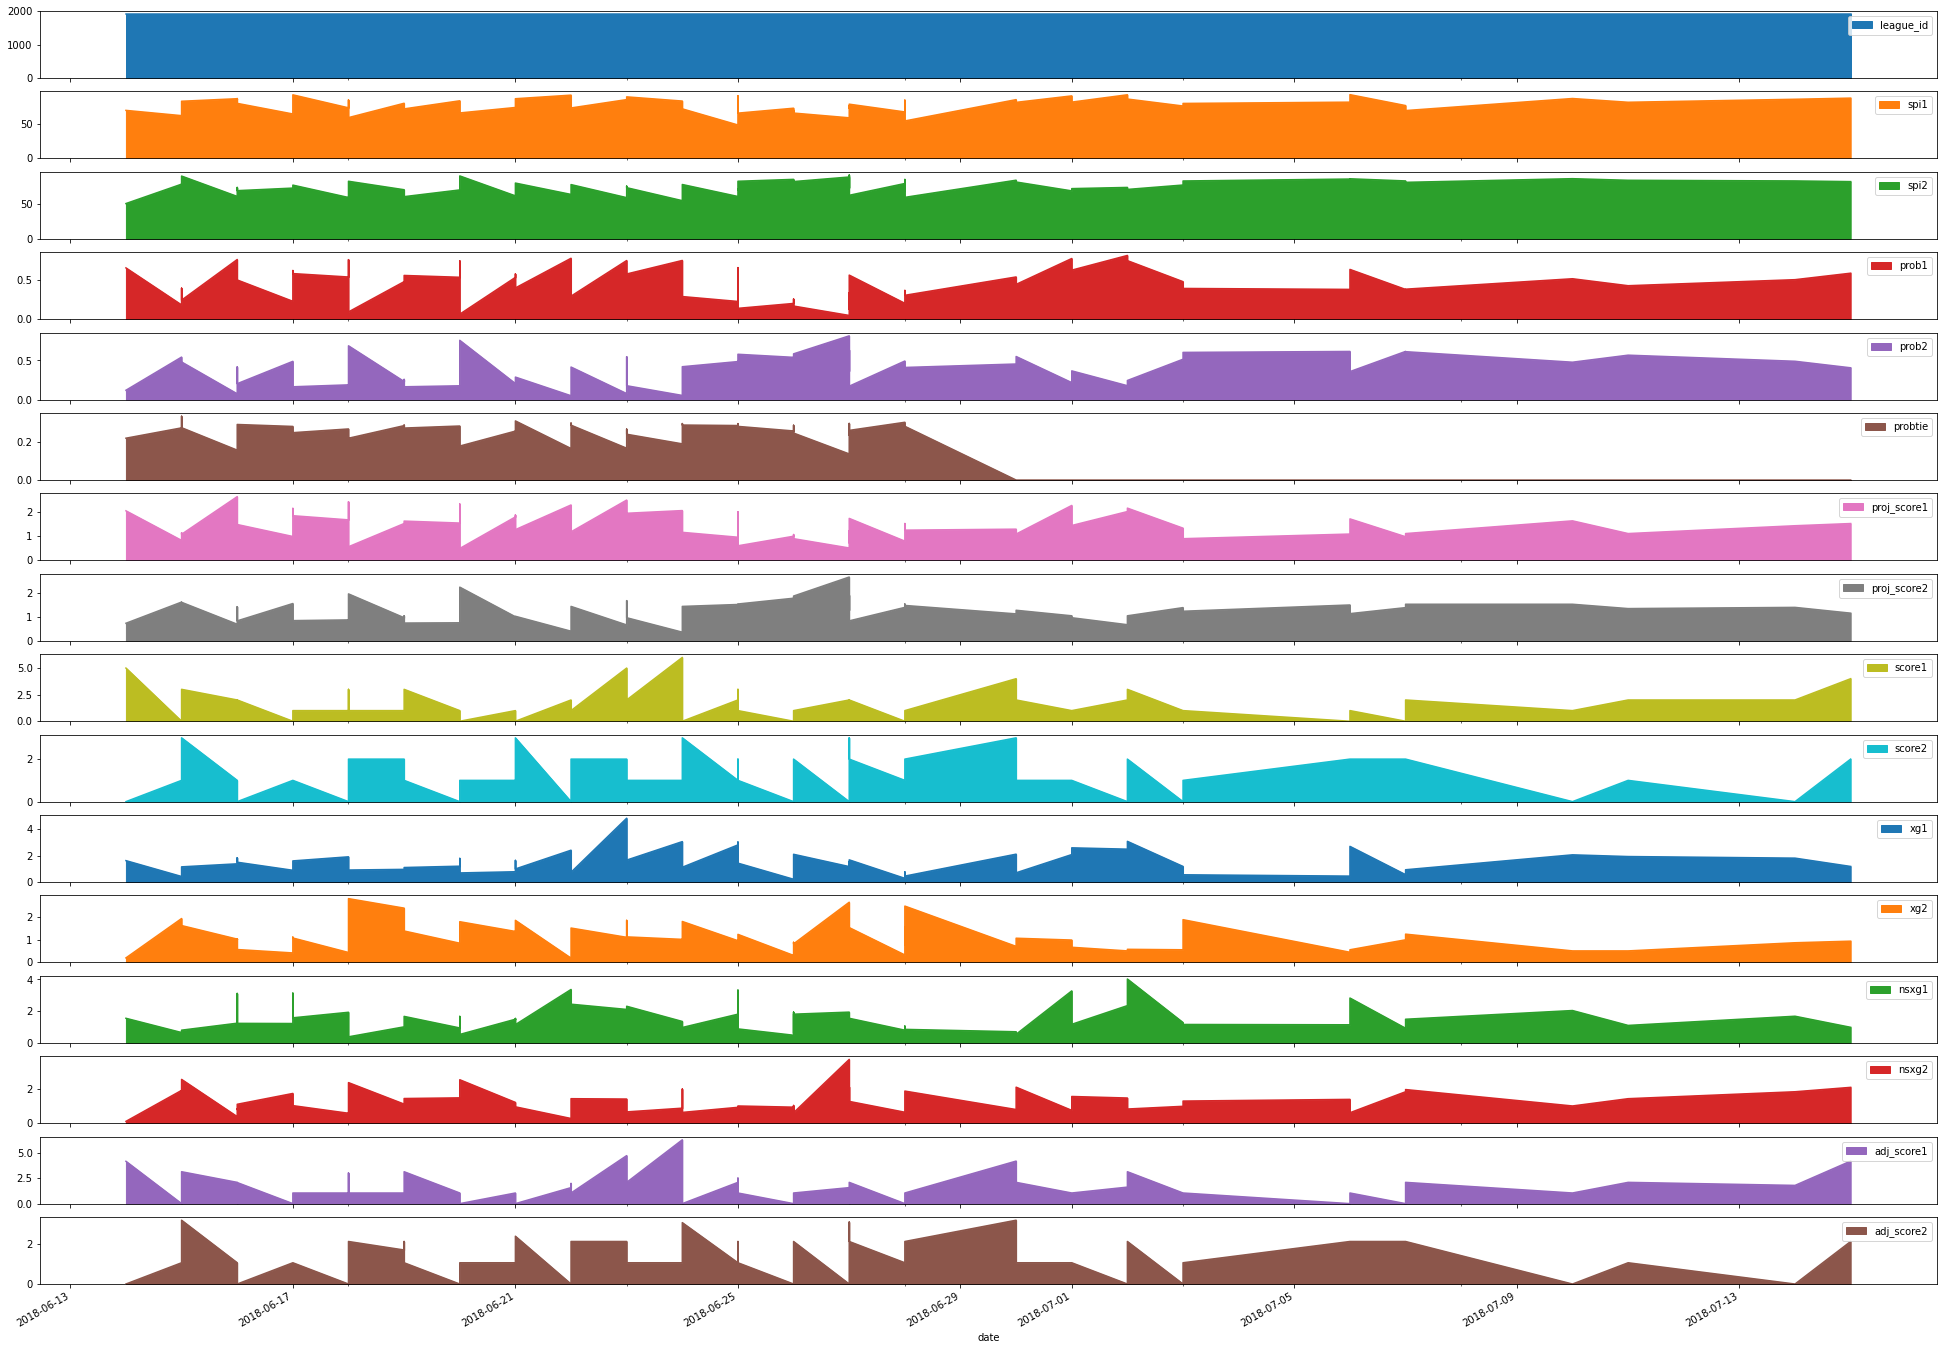

In [11]:
axs = matches.plot.area(figsize=(34, 26), subplots=True)

<AxesSubplot:xlabel='xg1', ylabel='nsxg1'>

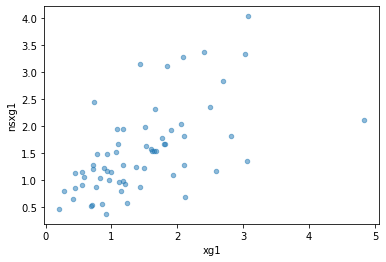

In [12]:
matches.plot.scatter(x="xg1", y="nsxg1", alpha=0.5)


overview of the available plot methods:

In [13]:
[
    method_name
    for method_name in dir(matches.plot)
    if not method_name.startswith("_")
]

['area',
 'bar',
 'barh',
 'box',
 'density',
 'hexbin',
 'hist',
 'kde',
 'line',
 'pie',
 'scatter']

<AxesSubplot:>

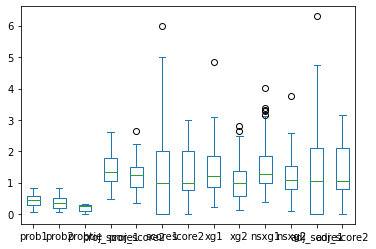

In [14]:
new_df = matches.drop(columns=['league_id', 'spi1', 'spi2'])
new_df.plot.box()

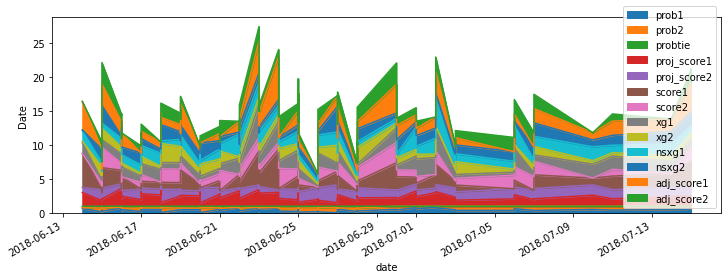

In [15]:
fig, axs = plt.subplots(figsize=(12, 4))        # Create an empty matplotlib Figure and Axes
new_df.plot.area(ax=axs)                   # Use pandas to put the area plot on the prepared Figure/Axes
axs.set_ylabel("Date")          # Do any matplotlib customization you like
fig.savefig("testing.png")           # Save the Figure/Axes using the existing matplotlib method.


In [16]:
# df = df.rename(columns=str.lower)

In [17]:
new_df.columns

Index(['league', 'team1', 'team2', 'prob1', 'prob2', 'probtie', 'proj_score1',
       'proj_score2', 'score1', 'score2', 'xg1', 'xg2', 'nsxg1', 'nsxg2',
       'adj_score1', 'adj_score2'],
      dtype='object')

In [18]:
new_df.groupby("score1").mean()

,prob1,prob2,probtie,proj_score1,proj_score2,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
score1,,,,,,,,,,,,
0,0.302400,0.458224,0.239412,1.114118,1.456471,1.529412,0.829412,1.115294,1.192353,1.259412,0.000000,1.547059
1,0.451336,0.360277,0.188395,1.412727,1.200000,1.136364,1.442727,1.177727,1.576818,1.128182,1.050000,1.174091
2,0.500573,0.343227,0.156187,1.515333,1.140000,0.866667,1.669333,1.028000,1.751333,1.415333,1.970667,0.910000
3,0.537300,0.261820,0.200880,1.696000,1.040000,1.200000,1.840000,0.866000,1.914000,1.282000,3.000000,1.260000
4,0.569200,0.430800,0.000000,1.395000,1.135000,2.500000,1.645000,0.825000,0.840000,1.465000,4.200000,2.625000
5,0.708950,0.098750,0.192250,2.250000,0.695000,1.000000,3.225000,0.655000,1.830000,0.770000,4.460000,1.050000
6,0.757400,0.053800,0.188900,2.040000,0.360000,1.000000,3.060000,1.020000,1.350000,0.890000,6.300000,1.050000


In [19]:
new_df.groupby("score1")["xg1"].mean()

score1
0    0.829412
1    1.442727
2    1.669333
3    1.840000
4    1.645000
5    3.225000
6    3.060000
Name: xg1, dtype: float64

In [20]:
new_df[["score1", "xg1"]].groupby("score1").mean()

,xg1
score1,
0,0.829412
1,1.442727
2,1.669333
3,1.840000
4,1.645000
5,3.225000
6,3.060000


In [21]:
new_df.groupby(["score1", "xg1"])["nsxg1"].mean()

score1  xg1 
0       0.21    0.48
        0.28    0.80
        0.42    0.65
        0.45    1.14
        0.56    0.92
                ... 
4       1.18    0.98
        2.11    0.70
5       1.62    1.55
        4.83    2.11
6       3.06    1.35
Name: nsxg1, Length: 64, dtype: float64

In [22]:
new_df.groupby("score1")["score1"].count()

score1
0    17
1    22
2    15
3     5
4     2
5     2
6     1
Name: score1, dtype: int64

In [23]:
new_df.sort_values(by="score1").head()

,league,team1,team2,prob1,prob2,probtie,proj_score1,proj_score2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
date,,,,,,,,,,,,,,,,
2018-06-24,FIFA World Cup,Poland,Colombia,0.2924,0.4205,0.2871,1.15,1.43,0,3,1.12,1.81,0.97,0.64,0.0,3.03
2018-07-06,FIFA World Cup,Uruguay,France,0.3847,0.6153,0.0000,1.08,1.49,0,2,0.45,0.45,1.14,1.41,0.0,2.10
2018-06-28,FIFA World Cup,England,Belgium,0.3714,0.3596,0.2691,1.49,1.46,0,1,0.77,0.78,0.87,1.58,0.0,1.05
2018-06-28,FIFA World Cup,Japan,Poland,0.3620,0.3731,0.2649,1.51,1.53,0,1,0.59,1.56,1.06,1.08,0.0,1.05
2018-06-28,FIFA World Cup,Senegal,Colombia,0.2055,0.4931,0.3015,0.79,1.39,0,1,0.28,0.33,0.80,0.65,0.0,1.05


In [24]:
# titanic["Name"].str.split(",")

In [25]:
# titanic["Surname"] = titanic["Name"].str.split(",").str.get(0)

In [26]:
# titanic[titanic["Name"].str.contains("Countess")]

In [27]:
#Adding goal difference and establishing who is the winner 
winner = []
for i in range (len(matches['team2'])):
    if matches ['score2'][i] > matches['score1'][i]:
        winner.append(matches['team2'][i])
    elif matches['score2'][i] < matches ['score1'][i]:
        winner.append(matches['team1'][i])
    else:
        winner.append('Draw')
matches['winning_team'] = winner

#adding goal difference column
matches['goal_difference'] = np.absolute(matches['score2'] - matches['score1'])

# matches.head()

In [28]:
matches.shape

(64, 21)

## World Cup Comparisons Data

In [29]:
comparisons = pd.read_csv('world_cup_comparisons.csv')

In [30]:
comparisons.columns

Index(['player', 'season', 'team', 'goals_z', 'xg_z', 'crosses_z',
       'boxtouches_z', 'passes_z', 'progpasses_z', 'takeons_z', 'progruns_z',
       'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z',
       'fouls_z', 'fouled_z', 'nsxg_z'],
      dtype='object')

In [31]:
comparisons.shape

(5899, 19)

### Change comparisons to world cups 2018, 2014, and 2010

comparisons years 2010-2018

In [32]:
comparisons = comparisons.loc[comparisons['season'].isin(years)]

In [33]:
comparisons.shape

(1668, 19)

comparisons teams that are in world cup 2022

In [34]:
comparisons = comparisons.loc[comparisons['team'].isin(teams_2022)]

In [35]:
comparisons.shape

(1094, 19)

In [36]:
year2010 = [2010]
year2014 = [2014]
year2018 = [2018]

# Germany

In [37]:
ger = ["Germany"]

In [38]:
ger_years = comparisons.loc[comparisons["team"].isin(ger)]

In [39]:
ger2010year = ger_years.loc[ger_years["season"].isin(year2010)]

In [40]:
ger2010xg = ger2010year.sort_values(by=["xg_z"], ascending=False)

In [41]:
ger2010xg13 = ger2010xg.head(13)

#### top 13 players from Germany in 2010 by XG

### Remove columns

In [42]:
ger2010xg13 = ger2010xg13.drop(columns=['player', 'season', 'team', 'boxtouches_z', 'progpasses_z', 'progruns_z', 'crosses_z', 'passes_z', 'takeons_z', 'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z'])


In [43]:
ger2010 = ger2010xg13.mean()

In [44]:
ger2010

goals_z     0.816923
xg_z        0.513077
fouls_z    -0.294615
fouled_z   -0.134615
nsxg_z      0.328462
dtype: float64

In [45]:
(.513077 + .328462) / .816923

1.0301325828750079

### Fouled

In [46]:
-0.134615 - -0.294615

0.16

# Setup New DF for derived stats

In [47]:
# initialize list of lists
data = [['Germany', 2010, 1.0301]]
  
# Create the pandas DataFrame
stats_df = pd.DataFrame(data, columns=['Country', 'Year', 'new_xg'])
  

In [48]:
stats_df['Fouled'] = 0.16

In [49]:
stats_df

,Country,Year,new_xg,Fouled
0,Germany,2010,1.0301,0.16


# Switzerland
* 2010: -1.76 
* 2014: 1.954
* 2018: 2.143

In [50]:
swits = ['Switzerland']

In [51]:
swiss_year = comparisons.loc[comparisons["team"].isin(swits)]

In [52]:
swiss2010year = swiss_year.loc[swiss_year["season"].isin(year2010)]

In [53]:
ch2010xg = swiss2010year.sort_values(by=["xg_z"], ascending=False)

In [54]:
ch2010xg13 = ch2010xg.head(13)

In [55]:
ch2010xg13 = ch2010xg13.drop(columns=['player', 'season', 'team', 'boxtouches_z', 'progpasses_z', 'progruns_z', 'crosses_z', 'passes_z', 'takeons_z', 'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z'])


In [56]:
ch2010 = ch2010xg13.mean()

In [57]:
ch2010

goals_z    -0.222308
xg_z        0.122308
fouls_z     0.429231
fouled_z    0.042308
nsxg_z      0.269231
dtype: float64

In [58]:
(.122308 + .269231) / -0.222308

-1.761245659175558

### Fouled

In [59]:
.042308 - .429231

-0.38692299999999996

In [60]:
new_row = {'Country': 'Switzerland', 'Year': 2010, 'new_xg': -1.7612, 'Fouled': -0.3869}

stats_df = stats_df.append(new_row, ignore_index=True)

In [61]:
stats_df

,Country,Year,new_xg,Fouled
0,Germany,2010,1.0301,0.1600
1,Switzerland,2010,-1.7612,-0.3869


### 2014

In [62]:
swiss2014year = swiss_year.loc[swiss_year["season"].isin(year2014)]

In [63]:
ch2014xg = swiss2014year.sort_values(by=["xg_z"], ascending=False)

In [64]:
ch2014xg13 = ch2014xg.head(13)

In [65]:
ch2014xg13 = ch2014xg13.drop(columns=['player', 'season', 'team', 'boxtouches_z', 'progpasses_z', 'progruns_z', 'crosses_z', 'passes_z', 'takeons_z', 'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z'])


In [66]:
ch2014 = ch2014xg13.mean()

In [67]:
ch2014

goals_z     0.387692
xg_z        0.550769
fouls_z     0.323077
fouled_z    0.382308
nsxg_z      0.206923
dtype: float64

In [68]:
(.550769 + .206923) / .387692

1.954365836798283

### Fouled

In [69]:
.382308 - .323077

0.05923099999999998

In [70]:
new_row = {'Country': 'Switzerland', 'Year': 2014, 'new_xg': 1.9543, 'Fouled': 0.05923}

stats_df = stats_df.append(new_row, ignore_index=True)

In [71]:
stats_df

,Country,Year,new_xg,Fouled
0,Germany,2010,1.0301,0.16000
1,Switzerland,2010,-1.7612,-0.38690
2,Switzerland,2014,1.9543,0.05923


### 2018

In [72]:
swiss2018year = swiss_year.loc[swiss_year["season"].isin(year2018)]

In [73]:
ch2018xg = swiss2018year.sort_values(by=["xg_z"], ascending=False)

In [74]:
ch2018xg13 = ch2018xg.head(13)

In [75]:
ch2018xg13 = ch2018xg13.drop(columns=['player', 'season', 'team', 'boxtouches_z', 'progpasses_z', 'progruns_z', 'crosses_z', 'passes_z', 'takeons_z', 'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z'])


In [76]:
ch2018 = ch2018xg13.mean()

In [77]:
ch2018

goals_z     0.241538
xg_z        0.330769
fouls_z    -0.040000
fouled_z    0.116154
nsxg_z      0.186923
dtype: float64

In [78]:
(.330769 + .186923) / 0.241538

2.143314923531701

### Fouled

In [79]:
.116154 - -0.040000

0.156154

In [80]:
new_row = {'Country': 'Switzerland', 'Year': 2018, 'new_xg': 2.1433, 'Fouled': 0.1561}

stats_df = stats_df.append(new_row, ignore_index=True)

In [81]:
stats_df

,Country,Year,new_xg,Fouled
0,Germany,2010,1.0301,0.16000
1,Switzerland,2010,-1.7612,-0.38690
2,Switzerland,2014,1.9543,0.05923
3,Switzerland,2018,2.1433,0.15610


# Spain

In [82]:
es = ['Spain']

In [83]:
es_year = comparisons.loc[comparisons["team"].isin(es)]

In [84]:
es2010year = es_year.loc[es_year["season"].isin(year2010)]

In [85]:
es2010xg = es2010year.sort_values(by=["xg_z"], ascending=False)

In [86]:
es2010xg13 = es2010xg.head(13)

In [87]:
es2010xg13 = es2010xg13.drop(columns=['player', 'season', 'team', 'boxtouches_z', 'progpasses_z', 'progruns_z', 'crosses_z', 'passes_z', 'takeons_z', 'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z'])


In [88]:
es2010 = es2010xg13.mean()

In [89]:
es2010

goals_z     0.180000
xg_z        0.539231
fouls_z    -0.138462
fouled_z    0.464615
nsxg_z      0.762308
dtype: float64

In [90]:
(.539231 + .762308) / .180000

7.230772222222223

### Fouled

In [91]:
.464615 - -0.138462

0.603077

In [92]:
new_row = {'Country': 'Spain', 'Year': 2010, 'new_xg': 7.2307, 'Fouled': 0.60307}

stats_df = stats_df.append(new_row, ignore_index=True)

In [93]:
stats_df

,Country,Year,new_xg,Fouled
0,Germany,2010,1.0301,0.16000
1,Switzerland,2010,-1.7612,-0.38690
2,Switzerland,2014,1.9543,0.05923
3,Switzerland,2018,2.1433,0.15610
4,Spain,2010,7.2307,0.60307


#  Portugal

In [94]:
port = ['Portugal']

In [95]:
port_year = comparisons.loc[comparisons["team"].isin(port)]

In [96]:
port2010year = port_year.loc[port_year["season"].isin(year2010)]

In [97]:
port2010xg = port2010year.sort_values(by=["xg_z"], ascending=False)

In [98]:
port2010xg13 = port2010xg.head(13)

In [99]:
port2010xg13 = port2010xg13.drop(columns=['player', 'season', 'team', 'boxtouches_z', 'progpasses_z', 'progruns_z', 'crosses_z', 'passes_z', 'takeons_z', 'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z'])


In [100]:
port2010 = port2010xg13.mean()

In [101]:
port2010

goals_z     0.531538
xg_z        0.284615
fouls_z     0.236154
fouled_z   -0.030000
nsxg_z      0.053077
dtype: float64

In [102]:
(.284615 + .053077) / .531538

0.6353111160443844

### Fouled

In [103]:
-0.030000 - .236154

-0.266154

In [104]:
new_row = {'Country': 'Portugal', 'Year': 2010, 'new_xg': 0.63531, 'Fouled': -0.2661}

stats_df = stats_df.append(new_row, ignore_index=True)

In [105]:
stats_df

,Country,Year,new_xg,Fouled
0,Germany,2010,1.03010,0.16000
1,Switzerland,2010,-1.76120,-0.38690
2,Switzerland,2014,1.95430,0.05923
3,Switzerland,2018,2.14330,0.15610
4,Spain,2010,7.23070,0.60307
5,Portugal,2010,0.63531,-0.26610


# Netherlands

In [106]:
ned = ['Netherlands']

In [107]:
ned_year = comparisons.loc[comparisons["team"].isin(ned)]

In [108]:
ned2010year = ned_year.loc[ned_year["season"].isin(year2010)]

In [109]:
ned2010xg = ned2010year.sort_values(by=["xg_z"], ascending=False)

In [110]:
ned2010xg13 = ned2010xg.head(13)

In [111]:
ned2010xg13 = ned2010xg13.drop(columns=['player', 'season', 'team', 'boxtouches_z', 'progpasses_z', 'progruns_z', 'crosses_z', 'passes_z', 'takeons_z', 'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z'])


In [112]:
ned2010 = ned2010xg13.mean()

In [113]:
ned2010

goals_z     0.396923
xg_z        0.126923
fouls_z     0.368462
fouled_z    0.439231
nsxg_z      0.127692
dtype: float64

In [114]:
(.126923 + .127692) / .396923

0.6414720235410899

### Fouled

In [115]:
.439231 - .368462

0.07076899999999997

In [116]:
new_row = {'Country': 'Netherlands', 'Year': 2010, 'new_xg': 0.64147, 'Fouled': 0.0707}

stats_df = stats_df.append(new_row, ignore_index=True)

In [117]:
stats_df

,Country,Year,new_xg,Fouled
0,Germany,2010,1.03010,0.16000
1,Switzerland,2010,-1.76120,-0.38690
2,Switzerland,2014,1.95430,0.05923
3,Switzerland,2018,2.14330,0.15610
4,Spain,2010,7.23070,0.60307
5,Portugal,2010,0.63531,-0.26610
6,Netherlands,2010,0.64147,0.07070


# Brazil

In [118]:
bra = ['Brazil']

In [119]:
bra_year = comparisons.loc[comparisons["team"].isin(bra)]

In [120]:
bra2010year = bra_year.loc[bra_year["season"].isin(year2010)]

In [121]:
bra2010xg = bra2010year.sort_values(by=["xg_z"], ascending=False)

In [122]:
bra2010xg13 = bra2010xg.head(13)

In [123]:
bra2010xg13 = bra2010xg13.drop(columns=['player', 'season', 'team', 'boxtouches_z', 'progpasses_z', 'progruns_z', 'crosses_z', 'passes_z', 'takeons_z', 'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z'])


In [124]:
bra2010 = bra2010xg13.mean()

In [125]:
bra2010

goals_z     0.557692
xg_z        0.186923
fouls_z     0.248462
fouled_z    0.331538
nsxg_z      0.535385
dtype: float64

In [126]:
(.186923 + .535385) / .557692

1.2951736800958236

### Fouled

In [127]:
.331538 - .248462

0.08307600000000001

In [128]:
new_row = {'Country': 'Brazil', 'Year': 2010, 'new_xg': 1.29517, 'Fouled': 0.08307}

stats_df = stats_df.append(new_row, ignore_index=True)

In [129]:
stats_df

,Country,Year,new_xg,Fouled
0,Germany,2010,1.03010,0.16000
1,Switzerland,2010,-1.76120,-0.38690
2,Switzerland,2014,1.95430,0.05923
3,Switzerland,2018,2.14330,0.15610
4,Spain,2010,7.23070,0.60307
5,Portugal,2010,0.63531,-0.26610
6,Netherlands,2010,0.64147,0.07070
7,Brazil,2010,1.29517,0.08307


# Belgium

In [130]:
bel = ['Belgium']

In [131]:
bel_year = comparisons.loc[comparisons["team"].isin(bel)]

In [132]:
bel2010year = bel_year.loc[bel_year["season"].isin(year2010)]

In [133]:
bel2010xg = bel2010year.sort_values(by=["xg_z"], ascending=False)

In [134]:
bel2010xg13 = bel2010xg.head(13)

In [135]:
bel2010xg13 = bel2010xg13.drop(columns=['player', 'season', 'team', 'boxtouches_z', 'progpasses_z', 'progruns_z', 'crosses_z', 'passes_z', 'takeons_z', 'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z'])


In [136]:
bel2010 = bel2010xg13.mean()

In [137]:
bel2010

goals_z    NaN
xg_z       NaN
fouls_z    NaN
fouled_z   NaN
nsxg_z     NaN
dtype: float64

# USA

In [138]:
us = ['USA']

In [139]:
us_year = comparisons.loc[comparisons["team"].isin(us)]

In [140]:
us2010year = us_year.loc[us_year["season"].isin(year2010)]

In [141]:
us2010xg = us2010year.sort_values(by=["xg_z"], ascending=False)

In [142]:
us2010xg13 = us2010xg.head(13)

In [143]:
us2010xg13 = us2010xg13.drop(columns=['player', 'season', 'team', 'boxtouches_z', 'progpasses_z', 'progruns_z', 'crosses_z', 'passes_z', 'takeons_z', 'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z'])


In [144]:
us2010 = us2010xg13.mean()

In [145]:
us2010

goals_z     0.214615
xg_z        0.523077
fouls_z    -0.122308
fouled_z    0.119231
nsxg_z      0.124615
dtype: float64

In [146]:
(.523077 + .124615) / .214615

3.017925121729609

### Fouled

In [147]:
.119231 - -0.122308

0.241539

In [148]:
new_row = {'Country': 'USA', 'Year': 2010, 'new_xg': 3.01792, 'Fouled': 0.2415}

stats_df = stats_df.append(new_row, ignore_index=True)

In [149]:
# stats_df

# England

In [150]:
eng = ['England']

In [151]:
eng_year = comparisons.loc[comparisons["team"].isin(eng)]

In [152]:
eng2010year = eng_year.loc[eng_year["season"].isin(year2010)]

In [153]:
eng2010xg = eng2010year.sort_values(by=["xg_z"], ascending=False)

In [154]:
eng2010xg13 = eng2010xg.head(13)

In [155]:
eng2010xg13 = eng2010xg13.drop(columns=['player', 'season', 'team', 'boxtouches_z', 'progpasses_z', 'progruns_z', 'crosses_z', 'passes_z', 'takeons_z', 'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z'])


In [156]:
eng2010 = eng2010xg13.mean()

In [157]:
eng2010

goals_z    -0.000769
xg_z        0.323077
fouls_z    -0.091538
fouled_z    0.042308
nsxg_z      0.506154
dtype: float64

In [158]:
(0.323077 + .506154) / -0.000769

-1078.3237971391418

### Fouled

In [159]:
.042308 - -0.091538

0.133846

In [160]:
new_row = {'Country': 'England', 'Year': 2010, 'new_xg': -1078.32379, 'Fouled': 0.1338}

stats_df = stats_df.append(new_row, ignore_index=True)

In [161]:
# stats_df

# Argentina

In [162]:
arg = ['Argentina']

In [163]:
arg_year = comparisons.loc[comparisons["team"].isin(arg)]

In [164]:
arg2010year = arg_year.loc[arg_year["season"].isin(year2010)]

In [165]:
arg2010xg = arg2010year.sort_values(by=["xg_z"], ascending=False)

In [166]:
arg2010xg13 = arg2010xg.head(13)

In [167]:
arg2010xg13 = arg2010xg13.drop(columns=['player', 'season', 'team', 'boxtouches_z', 'progpasses_z', 'progruns_z', 'crosses_z', 'passes_z', 'takeons_z', 'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z'])


In [168]:
arg2010 = arg2010xg13.mean()

In [169]:
arg2010

goals_z     0.450769
xg_z        0.496154
fouls_z    -0.384615
fouled_z    0.235385
nsxg_z      0.488462
dtype: float64

In [170]:
(0.496154 + .488462) / .450769

2.1843028247284084

### Fouled

In [171]:
.235385 - -0.384615

0.62

In [172]:
new_row = {'Country': 'Argentina', 'Year': 2010, 'new_xg': 2.184302, 'Fouled': 0.62}

stats_df = stats_df.append(new_row, ignore_index=True)

In [173]:
# stats_df

# Uruguay

In [174]:
uru = ['Uruguay']

In [175]:
uru_year = comparisons.loc[comparisons["team"].isin(uru)]

In [176]:
uru2010year = uru_year.loc[uru_year["season"].isin(year2010)]

In [177]:
uru2010xg = uru2010year.sort_values(by=["xg_z"], ascending=False)

In [178]:
uru2010xg13 = uru2010xg.head(13)

In [179]:
uru2010xg13 = uru2010xg13.drop(columns=['player', 'season', 'team', 'boxtouches_z', 'progpasses_z', 'progruns_z', 'crosses_z', 'passes_z', 'takeons_z', 'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z'])


In [180]:
uru2010 = uru2010xg13.mean()

In [181]:
uru2010

goals_z     0.396923
xg_z        0.130769
fouls_z    -0.013077
fouled_z    0.335385
nsxg_z     -0.167692
dtype: float64

In [182]:
(0.130769 + -0.167692) / .396923

-0.09302308004323259

### FOULED

In [183]:
.335385 - -0.013077

0.348462

In [184]:
new_row = {'Country': 'Uruguay', 'Year': 2010, 'new_xg': -0.09302, 'Fouled': -0.0930}

stats_df = stats_df.append(new_row, ignore_index=True)

In [195]:
# stats_df

# Senegal

In [196]:
sen = ['Senegal']

In [197]:
sen_year = comparisons.loc[comparisons["team"].isin(sen)]

In [198]:
sen2010year = sen_year.loc[sen_year["season"].isin(year2010)]

In [199]:
sen2010xg = sen2010year.sort_values(by=["xg_z"], ascending=False)

In [200]:
sen2010xg13 = sen2010xg.head(13)

In [201]:
sen2010xg13 = sen2010xg13.drop(columns=['player', 'season', 'team', 'boxtouches_z', 'progpasses_z', 'progruns_z', 'crosses_z', 'passes_z', 'takeons_z', 'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z'])


In [202]:
sen2010 = sen2010xg13.mean()

# Ecuador

In [205]:
ecu = ['Ecuador']

In [206]:
ecu_year = comparisons.loc[comparisons["team"].isin(ecu)]

In [207]:
ecu2010year = ecu_year.loc[ecu_year["season"].isin(year2010)]

In [208]:
ecu2010xg = ecu2010year.sort_values(by=["xg_z"], ascending=False)

In [209]:
ecu2010xg13 = ecu2010xg.head(13)

In [210]:
ecu2010xg13 = ecu2010xg13.drop(columns=['player', 'season', 'team', 'boxtouches_z', 'progpasses_z', 'progruns_z', 'crosses_z', 'passes_z', 'takeons_z', 'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z'])


In [211]:
ecu2010 = ecu2010xg13.mean()

# Wales

In [216]:
wal = ['Wales']

In [217]:
wal_year = comparisons.loc[comparisons["team"].isin(wal)]

In [219]:
wal2010year = wal_year.loc[wal_year["season"].isin(year2010)]

# Costa Rica

In [221]:
cos = ['Costa Rica']

In [222]:
cos_year = comparisons.loc[comparisons["team"].isin(cos)]

In [223]:
cos2010year = cos_year.loc[cos_year["season"].isin(year2010)]

# Mexico

In [225]:
mex = ['Mexico']

In [226]:
mex_year = comparisons.loc[comparisons["team"].isin(mex)]

In [227]:
mex2010year = mex_year.loc[mex_year["season"].isin(year2010)]

In [229]:
mex2010xg = mex2010year.sort_values(by=["xg_z"], ascending=False)

In [230]:
mex2010xg13 = mex2010xg.head(13)

In [231]:
mex2010xg13 = mex2010xg13.drop(columns=['player', 'season', 'team', 'boxtouches_z', 'progpasses_z', 'progruns_z', 'crosses_z', 'passes_z', 'takeons_z', 'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z'])


In [232]:
mex2010 = mex2010xg13.mean()

In [233]:
mex2010

goals_z     0.132308
xg_z        0.251538
fouls_z     0.607692
fouled_z    0.378462
nsxg_z      0.319231
dtype: float64

In [234]:
(0.251538 + 0.319231) / .132308

4.31394171176346

### Fouled

In [235]:
.378462 - .607692

-0.22923

In [236]:
new_row = {'Country': 'Mexico', 'Year': 2010, 'new_xg': 4.3139, 'Fouled': -0.22923}

stats_df = stats_df.append(new_row, ignore_index=True)

In [238]:
# stats_df

# France

In [239]:
fra = ['France']

In [240]:
fra_year = comparisons.loc[comparisons["team"].isin(fra)]

In [241]:
fra2010year = fra_year.loc[fra_year["season"].isin(year2010)]

In [242]:
fra2010xg = fra2010year.sort_values(by=["xg_z"], ascending=False)

In [243]:
fra2010xg13 = fra2010xg.head(13)

In [244]:
fra2010xg13 = fra2010xg13.drop(columns=['player', 'season', 'team', 'boxtouches_z', 'progpasses_z', 'progruns_z', 'crosses_z', 'passes_z', 'takeons_z', 'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z'])


In [245]:
fra2010 = fra2010xg13.mean()

In [247]:
fra2010

goals_z    -0.222308
xg_z       -0.019231
fouls_z     0.182308
fouled_z    0.170769
nsxg_z     -0.009231
dtype: float64

In [248]:
( -0.019231 + -0.009231) /  -0.222308

0.1280295805818954

### Fouled

In [250]:
0.170769 - 0.182308

-0.011538999999999994

In [251]:
new_row = {'Country': 'France', 'Year': 2010, 'new_xg': 0.128029, 'Fouled': -0.01153}

stats_df = stats_df.append(new_row, ignore_index=True)

# Denmark

In [253]:
den = ['Denmark']

In [254]:
den_year = comparisons.loc[comparisons["team"].isin(den)]

In [255]:
den2010year = den_year.loc[den_year["season"].isin(year2010)]

In [256]:
den2010xg = den2010year.sort_values(by=["xg_z"], ascending=False)

In [257]:
den2010xg13 = den2010xg.head(13)

In [258]:
den2010xg13 = den2010xg13.drop(columns=['player', 'season', 'team', 'boxtouches_z', 'progpasses_z', 'progruns_z', 'crosses_z', 'passes_z', 'takeons_z', 'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z'])


In [259]:
den2010 = den2010xg13.mean()

In [260]:
den2010

goals_z     0.133077
xg_z        0.533846
fouls_z     0.151538
fouled_z   -0.211538
nsxg_z     -0.123846
dtype: float64

In [261]:
(  0.533846 + -0.123846) /  0.133077

3.08092307461094

# Fouled

In [262]:
-0.211538 -  0.151538

-0.363076

In [276]:
new_row = {'Country': 'Denmark', 'Year': 2010, 'new_xg': 3.080923, 'Fouled': -0.363076}

stats_df = stats_df.append(new_row, ignore_index=True)

# Australia

In [263]:
aus = ['Australia']

In [264]:
aus_year = comparisons.loc[comparisons["team"].isin(aus)]

In [265]:
aus2010year = aus_year.loc[aus_year["season"].isin(year2010)]

In [266]:
aus2010xg = aus2010year.sort_values(by=["xg_z"], ascending=False)

In [269]:
aus2010xg13 = aus2010xg.head(13)

In [270]:
aus2010xg13 = aus2010xg13.drop(columns=['player', 'season', 'team', 'boxtouches_z', 'progpasses_z', 'progruns_z', 'crosses_z', 'passes_z', 'takeons_z', 'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z'])


In [271]:
aus2010 = aus2010xg13.mean()

In [272]:
aus2010

goals_z     0.132308
xg_z        0.247692
fouls_z     0.430769
fouled_z   -0.116154
nsxg_z      0.187692
dtype: float64

In [273]:
( 0.247692 + 0.187692) /  0.132308

3.290685370499138

### Fouled

In [274]:
-0.116154 - 0.430769

-0.546923

In [277]:
new_row = {'Country': 'Australia', 'Year': 2010, 'new_xg': 3.29068, 'Fouled': -0.546923}

stats_df = stats_df.append(new_row, ignore_index=True)

# Serbia

In [279]:
ser = ['Serbia']

In [280]:
ser_year = comparisons.loc[comparisons["team"].isin(ser)]

In [281]:
ser2010year = ser_year.loc[ser_year["season"].isin(year2010)]

In [282]:
ser2010xg = ser2010year.sort_values(by=["xg_z"], ascending=False)

In [283]:
ser2010xg13 = ser2010xg.head(13)

In [284]:
ser2010xg13 = ser2010xg13.drop(columns=['player', 'season', 'team', 'boxtouches_z', 'progpasses_z', 'progruns_z', 'crosses_z', 'passes_z', 'takeons_z', 'tackles_z', 'interceptions_z', 'clearances_z', 'blocks_z', 'aerials_z'])


In [285]:
ser2010 = ser2010xg13.mean()

In [286]:
ser2010

goals_z    -0.044615
xg_z        0.218462
fouls_z    -0.252308
fouled_z    0.616154
nsxg_z      0.246154
dtype: float64

In [287]:
(0.218462 + 0.246154) /  -0.044615

-10.41389667152303

### Fouled

In [288]:
0.616154 - -0.252308

0.868462

In [290]:
new_row = {'Country': 'Serbia', 'Year': 2010, 'new_xg': -10.41389, 'Fouled': 0.868462}

stats_df = stats_df.append(new_row, ignore_index=True)

Cameroon

In [292]:
cam = ['Cameroon']

In [ ]:
cam_year = comparisons.loc[comparisons["team"].isin(ser)]

'Cameroon', 'Ghana', 'Korea Republic'

'Iran', 'Poland', 'Saudi Arabia',  'Tunisia',  'Japan', 'Croatia', 'Canada', 'Morocco', 

## World Cup Data from 2018 - 210

initialized to variable df

In [186]:
# df = pd.concat(
#     map(pd.read_csv, ['FIFA - 2018.csv', 'FIFA - 2014.csv', 'FIFA - 2010.csv', 'FIFA - 2006.csv', 'FIFA - 2002.csv', 'FIFA - 1998.csv', 'FIFA - 1994.csv', 'FIFA - 1990.csv', 'FIFA - 1986.csv', 'FIFA - 1982.csv', 'FIFA - 1978.csv', 'FIFA - 1974.csv', 'FIFA - 1970.csv' ]), ignore_index=True)
# print(df)

df = pd.concat(
    map(pd.read_csv, ['FIFA - 2018.csv', 'FIFA - 2014.csv', 'FIFA - 2010.csv']))


In [187]:
df.columns

Index(['Position', 'Team', 'Games Played', 'Win', 'Draw', 'Loss', 'Goals For',
       'Goals Against', 'Goal Difference', 'Points'],
      dtype='object')

In [188]:
df.shape

(96, 10)

In [189]:
df.head()

,Position,Team,Games Played,Win,Draw,Loss,Goals For,Goals Against,Goal Difference,Points
0,1,France,7,6,1,0,14,6,8,19
1,2,Croatia,7,4,2,1,14,9,5,14
2,3,Belgium,7,6,0,1,16,6,10,18
3,4,England,7,3,1,3,12,8,4,10
4,5,Uruguay,5,4,0,1,7,3,4,12


In [190]:
df.tail()

,Position,Team,Games Played,Win,Draw,Loss,Goals For,Goals Against,Goal Difference,Points
27,28,Algeria,3,0,1,2,0,2,−2,1
28,29,France,3,0,1,2,1,4,−3,1
29,30,Honduras,3,0,1,2,0,3,−3,1
30,31,Cameroon,3,0,0,3,2,5,−3,0
31,32,North Korea,3,0,0,3,1,12,−11,0


### change to only teams in world cup 2022

In [191]:
# teams_2022 = ['Qatar', 'Netherlands', 'Senegal', 'Ecuador', 'England', 'USA', 'Wales', 'Iran', 'Argentina', 'Poland', 'Mexico', 'Saudi Arabia', 'France', 'Denmark', 'Tunisia', 'Australia', 'Germany', 'Spain', 'Japan', 'Costa Rica', 'Belgium', 'Croatia', 'Canada', 'Morocco', 'Brazil', 'Switzerland', 'Serbia', 'Cameroon', 'Portugal', 'Uruguay', 'Ghana', 'Korea Republic']

In [192]:
# df = df.loc[df['Team'].isin(teams_2022)]

In [193]:
# df.head()

In [194]:
# df.tail()